# CSE251B Project Milestone Starter File

## Step 1: Import Dependencies:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch_geometric.data import Data, Batch
import tqdm

## Step 2: Load the Dataset

#### You need to describe in your own words what the dataset is about, and use mathematical language and formulate your prediction task on the submitted PDF file for Question 1 Problem A.

#### Here we are loading the dataset from the local directory. And answer Question 1 Problem B

In [2]:
train_npz = np.load('./train.npz')
train_data = train_npz['data']
test_npz  = np.load('./test_input.npz')
test_data  = test_npz['data']

In [3]:
print(train_data.shape, test_data.shape)

# Split once for later use
X_train = train_data[..., :50, :]
Y_train = train_data[:, 0, 50:, :2]

(10000, 50, 110, 6) (2100, 50, 50, 6)


In [4]:
def plot_heatmap(data, title=None, bins=5):
    plt.figure(figsize=(6, 6))

    x_max = data[..., 0].max()
    x_min = data[..., 0].min()
    y_max = data[..., 1].max()
    y_min = data[..., 1].min()

    plt.hist2d(data[:, 0], data[:, 1], bins=bins, cmap='hot')
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.title(title)
    plt.colorbar(label='Density')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.show()

In [5]:
xy_in = train_data[:, :, :50, :2].reshape(-1, 2)
# only find the x, y != 0
xy_in_not_0 = xy_in[(xy_in[:, 0] != 0) & (xy_in[:, 1] != 0)]

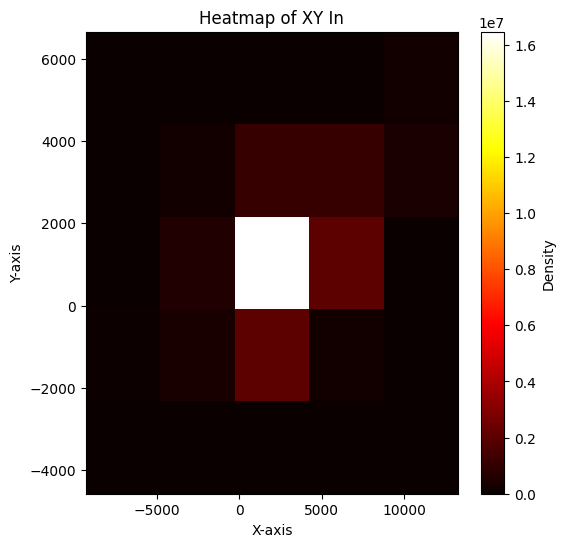

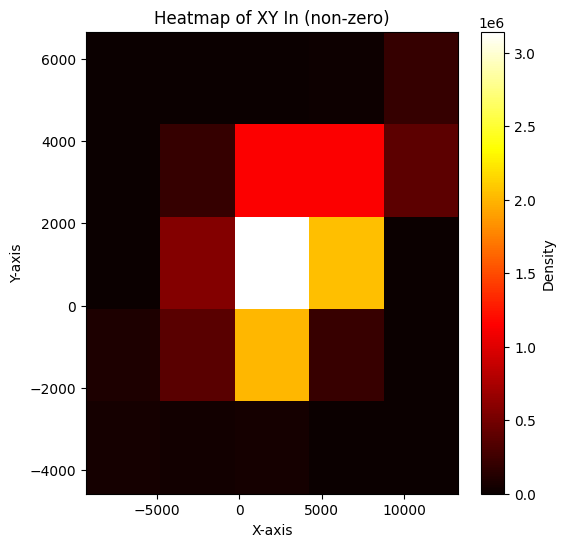

In [6]:
plot_heatmap(xy_in, title='Heatmap of XY In', bins=5)
plot_heatmap(xy_in_not_0, title='Heatmap of XY In (non-zero)', bins=5)

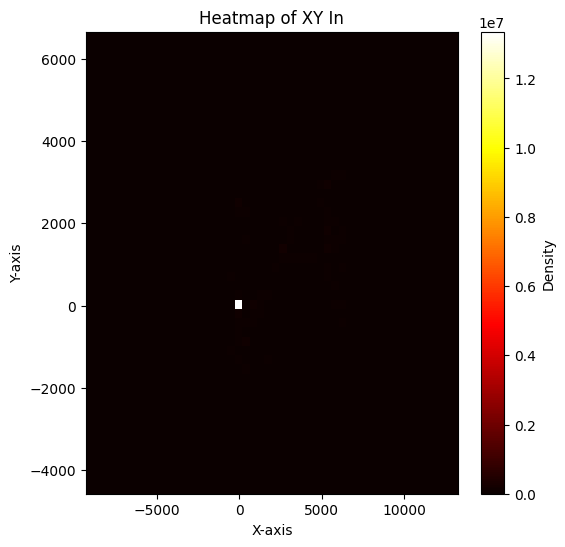

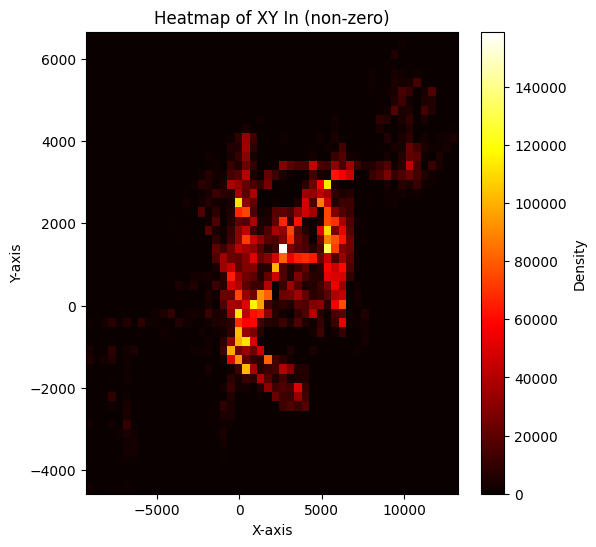

In [7]:
plot_heatmap(xy_in, title='Heatmap of XY In', bins=50)
plot_heatmap(xy_in_not_0, title='Heatmap of XY In (non-zero)', bins=50)

#### Try to play around with dataset for training and testing, make exploratory analysis on the dataset for bonus points(up to 2)

## Step 3: Setting up the Training and Testing

### Example Code:

In [8]:
class TrajectoryDatasetTrain(Dataset):
    def __init__(self, data, scale=10.0, augment=True):
        """
        data: Shape (N, 50, 110, 6) Training data
        scale: Scale for normalization (suggested to use 10.0 for Argoverse 2 data)
        augment: Whether to apply data augmentation (only for training)
        """
        self.data = data
        self.scale = scale
        self.augment = augment

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        scene = self.data[idx]
        # Getting 50 historical timestamps and 60 future timestamps
        hist = scene[:, :50, :].copy()    # (agents=50, time_seq=50, 6)
        future = torch.tensor(scene[0, 50:, :2].copy(), dtype=torch.float32)  # (60, 2)
        
        # Data augmentation(only for training)
        if self.augment:
            if np.random.rand() < 0.5:
                theta = np.random.uniform(-np.pi, np.pi)
                R = np.array([[np.cos(theta), -np.sin(theta)],
                              [np.sin(theta),  np.cos(theta)]], dtype=np.float32)
                # Rotate the historical trajectory and future trajectory
                hist[..., :2] = hist[..., :2] @ R
                hist[..., 2:4] = hist[..., 2:4] @ R
                future = future @ R
            if np.random.rand() < 0.5:
                hist[..., 0] *= -1
                hist[..., 2] *= -1
                future[:, 0] *= -1

        # Use the last timeframe of the historical trajectory as the origin
        origin = hist[0, 49, :2].copy()  # (2,)
        hist[..., :2] = hist[..., :2] - origin
        future = future - origin

        # Normalize the historical trajectory and future trajectory
        hist[..., :4] = hist[..., :4] / self.scale
        future = future / self.scale

        data_item = Data(
            x=torch.tensor(hist, dtype=torch.float32),
            y=future.type(torch.float32),
            origin=torch.tensor(origin, dtype=torch.float32).unsqueeze(0),
            scale=torch.tensor(self.scale, dtype=torch.float32),
        )

        return data_item
    

class TrajectoryDatasetTest(Dataset):
    def __init__(self, data, scale=10.0):
        """
        data: Shape (N, 50, 110, 6) Testing data
        scale: Scale for normalization (suggested to use 10.0 for Argoverse 2 data)
        """
        self.data = data
        self.scale = scale

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Testing data only contains historical trajectory
        scene = self.data[idx]  # (50, 50, 6)
        hist = scene.copy()
        
        origin = hist[0, 49, :2].copy()
        hist[..., :2] = hist[..., :2] - origin
        hist[..., :4] = hist[..., :4] / self.scale

        data_item = Data(
            x=torch.tensor(hist, dtype=torch.float32),
            origin=torch.tensor(origin, dtype=torch.float32).unsqueeze(0),
            scale=torch.tensor(self.scale, dtype=torch.float32),
        )
        return data_item

#### Answer Question related to Your Computational Platform and GPU for Question 2 Problem A

In [9]:
torch.manual_seed(251)
np.random.seed(42)

scale = 7.0

N = len(train_data)
val_size = int(0.1 * N)
train_size = N - val_size

train_dataset = TrajectoryDatasetTrain(train_data[:train_size], scale=scale, augment=True)
val_dataset = TrajectoryDatasetTrain(train_data[train_size:], scale=scale, augment=False)

train_dataloader = DataLoader(
    train_dataset, batch_size=64, shuffle=True, collate_fn=lambda x: Batch.from_data_list(x)
)
val_dataloader = DataLoader(
    val_dataset, batch_size=64, shuffle=False, collate_fn=lambda x: Batch.from_data_list(x)
)

# Set device for training speedup
if torch.backends.mps.is_available():
    device = torch.device('mps')
    print("Using Apple Silicon GPU")
elif torch.cuda.is_available():
    device = torch.device('cuda')
    print("Using CUDA GPU")
else:
    device = torch.device('cpu')

Using CUDA GPU


#### Your Model for Question 2 Problem B (Include your model architecture pictures and also can use some mathmatical equations to explain your model in your report)

In [10]:
class LinearRegressionModel(nn.Module):
    def __init__(self, input_dim=50 * 50 * 2, output_dim=60 * 2):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, data):
        x = data.x[..., :2] # (batch*50, 50, 2)
        x = x.reshape(-1, 50 * 50 * 2) # (batch, 5000)
        x = self.linear(x)
        return x.view(-1, 60, 2)

In [11]:
class MLP(nn.Module):
    def __init__(self, input_features, output_features):
        super(MLP, self).__init__()
        
        # Define the layers
        self.flatten = nn.Flatten()
        self.mlp = nn.Sequential(
            nn.Linear(input_features, 1024),
            nn.ReLU(),
            nn.Dropout(0.1),
            
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            
            nn.Linear(256, output_features)
        )
    
    def forward(self, data):
        x = data.x
        x = x[:, :, :, :2] # (batch, 50, 50, 2)
        x = x.reshape(-1, 50 * 50 * 6)
        x = self.mlp(x)
        return x.view(-1, 60, 2)

#### This Model will be covered during Week 6 Lecture (If you don't understand it for now, don't worry, we will cover it in the lecture, or you can ask in the office hours)

In [12]:
class LSTM(nn.Module):
    def __init__(self, input_dim=6, hidden_dim=128, output_dim=60 * 2):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, data):
        x = data.x
        x= x.reshape(-1, 50, 50, 6)  # (batch_size, num_agents, seq_len, input_dim)
        x = x[:, 0, :, :] # Only Consider ego agent index 0

        lstm_out, _ = self.lstm(x)
        # lstm_out is of shape (batch_size, seq_len, hidden_dim) and we want the last time step output
        out = self.fc(lstm_out[:, -1, :])
        return out.view(-1, 60, 2)

#### Trying Transformer Model

In [13]:
class TransformerModel(nn.Module):
    def __init__(self, input_dim=6, model_dim=128, num_heads=4, num_layers=2, output_dim=60*2, dropout=0.1):
        super(TransformerModel, self).__init__()
        self.input_proj = nn.Linear(input_dim, model_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=model_dim, nhead=num_heads, dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(model_dim, output_dim)

    def forward(self, data):
        x = data.x
        x = x.reshape(-1, 50, 50, 6)  # (batch_size, num_agents, seq_len, input_dim)
        x = x[:, 0, :, :]  # Only consider ego agent index 0, shape: (batch, 50, 6)
        x = self.input_proj(x)  # (batch, 50, model_dim)
        x = self.transformer_encoder(x)  # (batch, 50, model_dim)
        out = self.fc(x[:, -1, :])  # Use last time step's output
        return out.view(-1, 60, 2)

In [14]:
class AdvancedTransformerModel(nn.Module):
    def __init__(
        self,
        input_dim=6,
        model_dim=256,
        num_heads=8,
        num_layers=6,
        seq_len=50,
        future_len=60,
        dropout=0.15
    ):
        super().__init__()
        self.seq_len = seq_len
        self.future_len = future_len
        self.input_proj = nn.Linear(input_dim, model_dim)
        
        # Learnable positional encoding
        self.pos_encoding = nn.Parameter(torch.randn(1, seq_len, model_dim))
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=model_dim,
            nhead=num_heads,
            dim_feedforward=model_dim*4,
            dropout=dropout,
            batch_first=True,
            norm_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Decoder for future trajectory
        self.decoder = nn.Sequential(
            nn.LayerNorm(model_dim),
            nn.Linear(model_dim, model_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(model_dim, future_len * 2)
        )

    def forward(self, data):
        x = data.x
        x = x.reshape(-1, 50, 50, 6)  # (batch, agents, seq, features)
        x = x[:, 0, :, :]  # Only ego agent: (batch, seq, features)
        x = self.input_proj(x)  # (batch, seq, model_dim)
        x = x + self.pos_encoding[:, :self.seq_len, :]  # Add positional encoding
        x = self.encoder(x)  # (batch, seq, model_dim)
        x = x[:, -1, :]  # Use last time step's output (batch, model_dim)
        out = self.decoder(x)  # (batch, future_len*2)
        return out.view(-1, self.future_len, 2)

In [15]:
class BeefedTransformerModel(nn.Module):
    def __init__(
        self,
        input_dim=6,
        model_dim=256,
        num_heads=8,
        num_layers=6,
        seq_len=50,
        future_len=60,
        dropout=0.15
    ):
        super().__init__()
        self.seq_len = seq_len
        self.future_len = future_len

        # Temporal convolution for local feature extraction
        self.temporal_conv = nn.Conv1d(input_dim, input_dim, kernel_size=3, padding=1, groups=input_dim)
        self.input_proj = nn.Linear(input_dim, model_dim)

        # Learnable positional encoding
        self.pos_encoding = nn.Parameter(torch.randn(1, seq_len, model_dim))

        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=model_dim,
            nhead=num_heads,
            dim_feedforward=model_dim*6,
            dropout=dropout,
            batch_first=True,
            norm_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Deeper MLP decoder with residual connection
        self.decoder = nn.Sequential(
            nn.LayerNorm(model_dim),
            nn.Linear(model_dim, model_dim*2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(model_dim*2, model_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(model_dim, future_len * 2)
        )

    def forward(self, data):
        x = data.x
        x = x.reshape(-1, 50, 50, 6)
        x = x[:, 0, :, :]  # Only ego agent: (batch, seq, features)
        # Temporal convolution
        x = x.transpose(1, 2)  # (batch, features, seq)
        x = self.temporal_conv(x)
        x = x.transpose(1, 2)  # (batch, seq, features)
        x = self.input_proj(x)
        x = x + self.pos_encoding[:, :self.seq_len, :]
        x = self.encoder(x)
        x = x[:, -1, :]  # Last time step
        out = self.decoder(x)
        return out.view(-1, self.future_len, 2)

In [16]:
import torch.nn.functional as F
from torch_geometric.nn import GATConv

class GNNModel(nn.Module):
    def __init__(self, input_dim=6, hidden_dim=256, num_heads = 4, num_layers=4, output_dim=60*2, dropout=0.1):
        super(GNNModel, self).__init__()
        self.input_proj = nn.Linear(input_dim, hidden_dim)
        
        # GNN layers
        self.convs = nn.ModuleList()
        for i in range(num_layers):
            self.convs.append(GATConv(hidden_dim, hidden_dim//4, heads=num_heads))
        
        self.dropout = dropout
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, data):
        x = data.x
        x = x.reshape(-1, 50, 50, 6)  # (batch_size, num_agents, seq_len, input_dim)
        x = x[:, 0, :, :]  # Only consider ego agent, shape: (batch, 50, 6)
        
        # Project input features
        node_features = self.input_proj(x)  # (batch, 50, hidden_dim)
        
        batch_size = node_features.size(0)
        seq_len = node_features.size(1)
        
        # Process each batch separately
        outputs = []
        for b in range(batch_size):
            # Get features for this sequence
            seq_features = node_features[b]  # (50, hidden_dim)
            
            # Create a fully connected graph where each node (timestep) is connected to all others
            edge_index = []
            for i in range(seq_len):
                for j in range(seq_len):
                    if i != j:  # Connect every node to every other node
                        edge_index.append([i, j])
            
            edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous().to(seq_features.device)
            
            # Apply GNN layers
            h = seq_features
            for conv in self.convs:
                h = conv(h, edge_index)
                h = F.relu(h)
                h = F.dropout(h, p=self.dropout, training=self.training)
            
            # Get the final timestep's representation
            outputs.append(h[-1].unsqueeze(0))  # (1, hidden_dim)
        
        # Combine outputs from all batches
        h = torch.cat(outputs, dim=0)  # (batch, hidden_dim)
        
        # Final prediction
        out = self.fc(h)  # (batch, output_dim)
        return out.view(-1, 60, 2)

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv

class MultiAgentGNN(nn.Module):
    def __init__(
        self, 
        input_dim=6, 
        hidden_dim=256, 
        num_heads=8, 
        num_layers=4,
        future_len=60,
        max_agents=3,  # Only consider top k nearest agents
        dropout=0.1
    ):
        super(MultiAgentGNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.future_len = future_len
        self.max_agents = max_agents
        
        # Feature extraction
        self.feature_extractor = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.GELU()
        )
        
        # Temporal positional encoding
        self.pos_encoding = nn.Parameter(torch.randn(1, 50, hidden_dim))
        
        # Agent type embedding (ego=0, others=1)
        self.agent_type_embedding = nn.Parameter(torch.randn(2, hidden_dim))
        
        # Create temporal edges once (same for all samples)
        seq_len = 50
        self.temporal_edges = []
        for i in range(seq_len):
            # Forward connections (i -> i+k)
            for k in range(1, min(6, seq_len - i)):  # Connect to 5 future steps
                self.temporal_edges.append([i, i+k])
            # Backward connections (i -> i-k)
            for k in range(1, min(6, i + 1)):  # Connect to 5 past steps
                self.temporal_edges.append([i, i-k])
        # Always connect to the last timestep
        for i in range(seq_len - 1):
            self.temporal_edges.append([i, seq_len - 1])
        self.register_buffer('temporal_edge_index', 
                            torch.tensor(self.temporal_edges, dtype=torch.long).t().contiguous())
        
        # Temporal GNN layers
        self.temporal_convs = nn.ModuleList()
        self.temporal_norms = nn.ModuleList()
        
        for i in range(num_layers):
            self.temporal_convs.append(GATConv(
                hidden_dim, 
                hidden_dim // num_heads, 
                heads=num_heads, 
                dropout=dropout
            ))
            self.temporal_norms.append(nn.LayerNorm(hidden_dim))
        
        # Social attention for agent interaction
        self.social_attention = nn.MultiheadAttention(
            embed_dim=hidden_dim,
            num_heads=num_heads//2,
            dropout=dropout,
            batch_first=True
        )
        self.social_norm = nn.LayerNorm(hidden_dim)
            
        # Trajectory prediction layers
        self.trajectory_predictor = nn.Sequential(
            nn.Linear(hidden_dim*2, hidden_dim*2),  # Concat ego and social features
            nn.LayerNorm(hidden_dim*2),
            nn.Dropout(dropout),
            nn.GELU(),
            nn.Linear(hidden_dim*2, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.Dropout(dropout),
            nn.GELU(),
            nn.Linear(hidden_dim, future_len * 2)
        )
        
        # Initialize weights
        self.apply(self._init_weights)
    
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.xavier_normal_(module.weight, gain=0.02)
            if module.bias is not None:
                nn.init.zeros_(module.bias)
    
    def forward(self, data):
        x = data.x  # (batch*agents, seq_len, features)
        batch_size = data.num_graphs
        
        # Reshape to get explicit agent dimension
        x = x.reshape(batch_size, 50, 50, -1)  # (batch, agents, seq_len, features)
        
        # Process in parallel for all batches
        all_outputs = []
        
        for b in range(batch_size):
            scene = x[b]  # (agents, seq_len, features)
            
            # Find non-zero agents (valid agents with actual data)
            # Sum across spatial and feature dimensions
            agent_mask = torch.sum(torch.abs(scene[:, -1, :2]), dim=-1) > 1e-6
            valid_agents = torch.where(agent_mask)[0]
            
            # Always include ego agent (index 0)
            if 0 not in valid_agents:
                valid_agents = torch.cat([torch.tensor([0], device=x.device), valid_agents])
            
            # Select top-k nearest agents to ego (based on last timestamp)
            if len(valid_agents) > self.max_agents:
                ego_pos = scene[0, -1, :2]  # Ego agent's last position
                other_agents = valid_agents[valid_agents != 0]
                other_pos = scene[other_agents, -1, :2]  # Other agents' last positions
                
                # Calculate distances to ego
                distances = torch.norm(other_pos - ego_pos, dim=-1)
                
                # Get indices of k-1 nearest agents
                _, nearest_indices = torch.topk(distances, min(len(distances), self.max_agents-1), largest=False)
                selected_agents = torch.cat([torch.tensor([0], device=x.device), 
                                          other_agents[nearest_indices]])
            else:
                selected_agents = valid_agents
            
            # Extract features for selected agents
            agents_features = []
            agent_types = []
            
            for idx, agent_idx in enumerate(selected_agents):
                # Agent type: 0 for ego, 1 for others
                agent_type = 0 if agent_idx == 0 else 1
                agent_types.append(agent_type)
                
                # Extract and process features
                agent_feat = scene[agent_idx]  # (seq_len, features)
                agent_feat = self.feature_extractor(agent_feat)  # (seq_len, hidden_dim)
                
                # Add positional encoding and agent type embedding
                agent_feat = agent_feat + self.pos_encoding[0] + self.agent_type_embedding[agent_type]
                
                # Apply temporal GNN
                for i, (conv, norm) in enumerate(zip(self.temporal_convs, self.temporal_norms)):
                    h_new = conv(agent_feat, self.temporal_edge_index)
                    h_new = F.gelu(h_new)
                    if i < len(self.temporal_convs) - 1:
                        h_new = F.dropout(h_new, p=0.1, training=self.training)
                    agent_feat = agent_feat + h_new  # Residual
                    agent_feat = norm(agent_feat)  # Normalization
                
                # Use the last timestep's features
                agents_features.append(agent_feat[-1])  # (hidden_dim)
            
            # Stack all agent features
            if len(agents_features) > 0:
                agents_features = torch.stack(agents_features, dim=0)  # (num_agents, hidden_dim)
                
                # Apply social attention - ego agent attends to others
                ego_feat = agents_features[0:1]  # (1, hidden_dim)
                
                if len(agents_features) > 1:
                    # Social attention between ego and other agents
                    social_context, _ = self.social_attention(
                        ego_feat,  # Query: ego agent
                        agents_features,  # Keys: all agents
                        agents_features,  # Values: all agents
                    )
                    social_context = self.social_norm(social_context + ego_feat)  # Residual
                else:
                    social_context = ego_feat
                
                # Combine ego features with social context
                combined_feat = torch.cat([ego_feat, social_context], dim=-1)  # (1, hidden_dim*2)
                
                # Predict future trajectory
                future_traj = self.trajectory_predictor(combined_feat)  # (1, future_len*2)
                future_traj = future_traj.view(1, self.future_len, 2)  # (1, future_len, 2)
                
                all_outputs.append(future_traj)
            else:
                # Fallback if no valid agents (shouldn't happen)
                zero_traj = torch.zeros((1, self.future_len, 2), device=x.device)
                all_outputs.append(zero_traj)
        
        # Combine all batch outputs
        if all_outputs:
            output = torch.cat(all_outputs, dim=0)  # (batch, future_len, 2)
            return output
        else:
            return torch.zeros((batch_size, self.future_len, 2), device=x.device)

In [18]:
class GNNTransformerLite(nn.Module):
    def __init__(
        self,
        input_dim=6,
        gnn_hidden=64,
        gnn_heads=2,
        gnn_layers=1,
        trans_dim=64,
        trans_heads=2,
        trans_layers=1,
        seq_len=50,
        future_len=60,
        dropout=0.15
    ):
        super().__init__()
        self.seq_len = seq_len
        self.future_len = future_len

        # GNN for agent interaction at last timestep
        self.gnn_input = nn.Linear(input_dim, gnn_hidden)
        self.gnn = GATConv(gnn_hidden, gnn_hidden, heads=gnn_heads, dropout=dropout)
        self.gnn_norm = nn.LayerNorm(gnn_hidden * gnn_heads)

        # Transformer for ego temporal encoding
        self.trans_input = nn.Linear(input_dim, trans_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=trans_dim, nhead=trans_heads, dropout=dropout, batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=trans_layers)
        self.trans_norm = nn.LayerNorm(trans_dim)

        # Final fusion and prediction
        self.fc = nn.Sequential(
            nn.Linear(gnn_hidden * gnn_heads + trans_dim, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, future_len * 2)
        )

    def forward(self, data):
        x = data.x
        x = x.reshape(-1, 50, 50, 6)  # (batch, agents, seq, features)
        batch_size = x.shape[0]

        # --- GNN: agent interaction at last timestep ---
        last_timestep = x[:, :, -1, :]  # (batch, agents, features)
        gnn_in = self.gnn_input(last_timestep)  # (batch, agents, gnn_hidden)
        # Fully connected graph for agents
        edge_index = torch.combinations(torch.arange(gnn_in.shape[1]), r=2).t().to(x.device)
        gnn_out = []
        for b in range(batch_size):
            h = self.gnn(gnn_in[b], edge_index)
            h = F.relu(h)
            h = self.gnn_norm(h)
            gnn_out.append(h[0])  # Use ego agent (index 0)
        gnn_out = torch.stack(gnn_out, dim=0)  # (batch, gnn_hidden * gnn_heads)

        # --- Transformer: ego agent temporal encoding ---
        ego_traj = x[:, 0, :, :]  # (batch, seq, features)
        trans_in = self.trans_input(ego_traj)
        trans_out = self.transformer(trans_in)
        trans_out = self.trans_norm(trans_out[:, -1, :])  # Last time step

        # --- Concatenate and predict ---
        fused = torch.cat([gnn_out, trans_out], dim=-1)
        out = self.fc(fused)
        return out.view(-1, self.future_len, 2)

In [19]:
class GNNTransformerDeep(nn.Module):
    def __init__(
        self,
        input_dim=6,
        gnn_hidden=128,
        gnn_heads=4,
        gnn_layers=2,
        trans_dim=128,
        trans_heads=4,
        trans_layers=2,
        seq_len=50,
        future_len=60,
        dropout=0.1
    ):
        super().__init__()
        self.seq_len = seq_len
        self.future_len = future_len

        # Multi-layer GNN for agent interaction at each timestep
        self.gnn_input = nn.Linear(input_dim, gnn_hidden)
        self.gnn_layers = nn.ModuleList()
        for i in range(gnn_layers):
            in_dim = gnn_hidden if i == 0 else gnn_hidden * gnn_heads
            self.gnn_layers.append(
                GATConv(in_dim, gnn_hidden, heads=gnn_heads, dropout=dropout)
            )
        self.gnn_norm = nn.LayerNorm(gnn_hidden * gnn_heads)

        # Transformer for ego temporal encoding
        self.trans_input = nn.Linear(input_dim, trans_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=trans_dim, nhead=trans_heads, dropout=dropout, batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=trans_layers)
        self.trans_norm = nn.LayerNorm(trans_dim)

        # Final fusion and prediction
        self.fc = nn.Sequential(
            nn.Linear(gnn_hidden * gnn_heads + trans_dim, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, future_len * 2)
        )

    def forward(self, data):
        x = data.x
        x = x.reshape(-1, 50, 50, 6)  # (batch, agents, seq, features)
        batch_size = x.shape[0]
        num_agents = x.shape[1]

        # --- GNN: agent interaction at each timestep ---
        gnn_out = []
        edge_index = torch.combinations(torch.arange(num_agents), r=2).t().to(x.device)
        for b in range(batch_size):
            timestep_features = []
            for t in range(self.seq_len):
                agents_t = x[b, :, t, :]  # (agents, features)
                h = self.gnn_input(agents_t)
                for i, gnn in enumerate(self.gnn_layers):
                    h = gnn(h, edge_index)
                    h = F.relu(h)
                timestep_features.append(h[0])  # Use ego agent (index 0)
            gnn_out.append(torch.stack(timestep_features, dim=0))  # (seq, gnn_hidden * gnn_heads)
        gnn_out = torch.stack(gnn_out, dim=0)  # (batch, seq, gnn_hidden * gnn_heads)
        gnn_out_last = self.gnn_norm(gnn_out[:, -1, :])  # (batch, gnn_hidden * gnn_heads)

        # --- Transformer: ego agent temporal encoding ---
        ego_traj = x[:, 0, :, :]  # (batch, seq, features)
        trans_in = self.trans_input(ego_traj)
        trans_out = self.transformer(trans_in)
        trans_out = self.trans_norm(trans_out[:, -1, :])  # Last time step

        # --- Concatenate and predict ---
        fused = torch.cat([gnn_out_last, trans_out], dim=-1)
        out = self.fc(fused)
        return out.view(-1, self.future_len, 2)

#### Your Optimizer and Hyperparameters for Question 2 Problem A (Try to use different optimizers and hyperparameters for your model and see how it affects the performance of your model)

In [20]:
# model = LinearRegressionModel().to(device)
# model = MLP(50 * 50 * 6, 60 * 2).to(device)
# model = LSTM().to(device)
# model = TransformerModel().to(device)
# model = AdvancedTransformerModel().to(device)
# model = AdvancedTransformerModel(
#     input_dim=6,
#     model_dim=512,      # 2x wider
#     num_heads=16,       # 2x more heads
#     num_layers=12,      # 2x deeper
#     seq_len=50,
#     future_len=60,
#     dropout=0.10        # Slightly higher dropout for regularization
# ).to(device)
# model = BeefedTransformerModel(
#     input_dim=6,
#     model_dim=1152,
#     num_heads=36,
#     num_layers=20,
#     seq_len=50,
#     future_len=60,
#     dropout=0.15
# ).to(device)
# model_dim=128, num_heads=4, num_layers=2


#### Using the Simple Linear Regression Model for Question 2B and Visualize the validation loss(MAE) (Hint: You should adapt the code for training loss and try to draw graphs as specified in the project description)

In [ ]:
from sklearn.model_selection import KFold

k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
all_indices = np.arange(len(train_data))
fold_results = []

for fold, (train_idx, val_idx) in enumerate(kf.split(all_indices)):
    print(f"\n--- Fold {fold+1}/{k_folds} ---")
    if fold == 1:
        break

    # Create datasets for this fold
    train_dataset = TrajectoryDatasetTrain(train_data[train_idx], scale=scale, augment=True)
    val_dataset = TrajectoryDatasetTrain(train_data[val_idx], scale=scale, augment=False)
    train_dataloader = DataLoader(
        train_dataset, batch_size=32, shuffle=True, collate_fn=lambda x: Batch.from_data_list(x)
    )
    val_dataloader = DataLoader(
        val_dataset, batch_size=32, shuffle=False, collate_fn=lambda x: Batch.from_data_list(x)
    )
    
    model = GNNTransformerLite(
        gnn_hidden=128,
        gnn_heads=4,
        gnn_layers=2,
        trans_dim=128,
        trans_heads=4,
        trans_layers=2,
        dropout=0.1
    ).to(device)

    # Modified training setup
    optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.OneCycleLR(
        optimizer, 
        max_lr=1e-3,
        total_steps=100 * len(train_dataloader),
        pct_start=0.1,
        div_factor=10.0,
        final_div_factor=100.0
    )

    # Custom loss function with distance-based weighting
    def weighted_mse_loss(pred, target):
        # Linear weights that decrease with time (more emphasis on earlier predictions)
        weights = torch.linspace(1.0, 0.3, pred.shape[1], device=pred.device).view(1, -1, 1)
        return torch.mean(weights * (pred - target) ** 2)

    early_stopping_patience = 20
    best_val_loss = float('inf')
    no_improvement = 0
    criterion = weighted_mse_loss

    for epoch in tqdm.tqdm(range(100), desc="Epoch", unit="epoch"):
        # ---- Training ----
        model.train()
        train_loss = 0
        for batch in train_dataloader:
            batch = batch.to(device)
            pred = model(batch)
            y = batch.y.view(batch.num_graphs, 60, 2)
            loss = criterion(pred, y)
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            optimizer.step()
            train_loss += loss.item()
        
        # ---- Validation ----
        model.eval()
        val_loss = 0
        val_mae = 0
        val_mse = 0
        with torch.no_grad():
            for batch in val_dataloader:
                batch = batch.to(device)
                pred = model(batch)
                y = batch.y.view(batch.num_graphs, 60, 2)
                val_loss += criterion(pred, y).item()

                # show MAE and MSE with unnormalized data
                pred = pred * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
                y = y * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
                val_mae += nn.L1Loss()(pred, y).item()
                val_mse += nn.MSELoss()(pred, y).item()
        
        train_loss /= len(train_dataloader)
        val_loss /= len(val_dataloader)
        val_mae /= len(val_dataloader)
        val_mse /= len(val_dataloader)
        scheduler.step()
        # scheduler.step(val_loss)
        
        tqdm.tqdm.write(f"Epoch {epoch:03d} | Learning rate {optimizer.param_groups[0]['lr']:.6f} | train normalized MSE {train_loss:8.4f} | val normalized MSE {val_loss:8.4f}, | val MAE {val_mae:8.4f} | val MSE {val_mse:8.4f}")
        if val_loss < best_val_loss - 1e-5:
            best_val_loss = val_loss
            no_improvement = 0
            torch.save(model.state_dict(), f"best_model_fold{fold+1}.pt")
        else:
            no_improvement += 1
            if no_improvement >= early_stopping_patience:
                print("Early stop!")
                break

    fold_results.append(best_val_loss)

print(f"\nK-Fold Results: {fold_results}")
print(f"Mean Validation Loss: {np.mean(fold_results):.4f} | Std: {np.std(fold_results):.4f}")


--- Fold 1/5 ---


Epoch:   1%|          | 1/100 [00:19<31:55, 19.35s/epoch]

Epoch 000 | Learning rate 0.000100 | train normalized MSE   1.3086 | val normalized MSE   0.2616, | val MAE   3.2069 | val MSE  29.3233


Epoch:   2%|▏         | 2/100 [00:38<31:51, 19.50s/epoch]

Epoch 001 | Learning rate 0.000100 | train normalized MSE   0.3119 | val normalized MSE   0.1531, | val MAE   2.2917 | val MSE  17.3681


Epoch:   3%|▎         | 3/100 [00:58<31:49, 19.68s/epoch]

Epoch 002 | Learning rate 0.000100 | train normalized MSE   0.2452 | val normalized MSE   0.1290, | val MAE   2.0375 | val MSE  14.7602


Epoch:   4%|▍         | 4/100 [01:18<31:11, 19.49s/epoch]

Epoch 003 | Learning rate 0.000100 | train normalized MSE   0.2155 | val normalized MSE   0.1346, | val MAE   2.1187 | val MSE  15.3461


Epoch:   5%|▌         | 5/100 [01:37<30:33, 19.30s/epoch]

Epoch 004 | Learning rate 0.000100 | train normalized MSE   0.1987 | val normalized MSE   0.1204, | val MAE   1.9130 | val MSE  13.8595


Epoch:   6%|▌         | 6/100 [01:55<30:02, 19.18s/epoch]

Epoch 005 | Learning rate 0.000100 | train normalized MSE   0.1837 | val normalized MSE   0.1118, | val MAE   1.8016 | val MSE  12.9155


Epoch:   7%|▋         | 7/100 [02:15<29:54, 19.30s/epoch]

Epoch 006 | Learning rate 0.000100 | train normalized MSE   0.1712 | val normalized MSE   0.1146, | val MAE   1.8213 | val MSE  13.2455


Epoch:   8%|▊         | 8/100 [02:34<29:28, 19.22s/epoch]

Epoch 007 | Learning rate 0.000100 | train normalized MSE   0.1657 | val normalized MSE   0.1094, | val MAE   1.7770 | val MSE  12.7120


Epoch:   9%|▉         | 9/100 [02:53<29:00, 19.13s/epoch]

Epoch 008 | Learning rate 0.000100 | train normalized MSE   0.1578 | val normalized MSE   0.1141, | val MAE   1.8395 | val MSE  13.1984


Epoch:  10%|█         | 10/100 [03:13<28:55, 19.28s/epoch]

Epoch 009 | Learning rate 0.000100 | train normalized MSE   0.1554 | val normalized MSE   0.1143, | val MAE   1.8170 | val MSE  13.2071


Epoch:  11%|█         | 11/100 [03:32<28:26, 19.18s/epoch]

Epoch 010 | Learning rate 0.000100 | train normalized MSE   0.1499 | val normalized MSE   0.1058, | val MAE   1.6944 | val MSE  12.3019


Epoch:  12%|█▏        | 12/100 [03:51<28:03, 19.13s/epoch]

Epoch 011 | Learning rate 0.000100 | train normalized MSE   0.1477 | val normalized MSE   0.1066, | val MAE   1.7051 | val MSE  12.3800


Epoch:  13%|█▎        | 13/100 [04:10<27:44, 19.13s/epoch]

Epoch 012 | Learning rate 0.000100 | train normalized MSE   0.1437 | val normalized MSE   0.1075, | val MAE   1.7342 | val MSE  12.4756


Epoch:  14%|█▍        | 14/100 [04:29<27:24, 19.12s/epoch]

Epoch 013 | Learning rate 0.000100 | train normalized MSE   0.1432 | val normalized MSE   0.1087, | val MAE   1.7598 | val MSE  12.5524


Epoch:  15%|█▌        | 15/100 [04:48<27:06, 19.13s/epoch]

Epoch 014 | Learning rate 0.000100 | train normalized MSE   0.1396 | val normalized MSE   0.1140, | val MAE   1.8398 | val MSE  13.1271


Epoch:  16%|█▌        | 16/100 [05:07<26:46, 19.13s/epoch]

Epoch 015 | Learning rate 0.000100 | train normalized MSE   0.1393 | val normalized MSE   0.1061, | val MAE   1.6793 | val MSE  12.3124


Epoch:  17%|█▋        | 17/100 [05:26<26:31, 19.17s/epoch]

Epoch 016 | Learning rate 0.000100 | train normalized MSE   0.1385 | val normalized MSE   0.1021, | val MAE   1.6749 | val MSE  11.8823


Epoch:  18%|█▊        | 18/100 [05:45<26:00, 19.03s/epoch]

Epoch 017 | Learning rate 0.000100 | train normalized MSE   0.1343 | val normalized MSE   0.1101, | val MAE   1.7662 | val MSE  12.7407


Epoch:  19%|█▉        | 19/100 [06:04<25:34, 18.94s/epoch]

Epoch 018 | Learning rate 0.000100 | train normalized MSE   0.1352 | val normalized MSE   0.1123, | val MAE   1.8923 | val MSE  12.9178


Epoch:  20%|██        | 20/100 [06:24<25:38, 19.23s/epoch]

Epoch 019 | Learning rate 0.000100 | train normalized MSE   0.1345 | val normalized MSE   0.1037, | val MAE   1.6965 | val MSE  12.0845


Epoch:  21%|██        | 21/100 [06:42<25:07, 19.08s/epoch]

Epoch 020 | Learning rate 0.000100 | train normalized MSE   0.1314 | val normalized MSE   0.1096, | val MAE   1.7490 | val MSE  12.6819


Epoch:  22%|██▏       | 22/100 [07:02<24:54, 19.16s/epoch]

Epoch 021 | Learning rate 0.000100 | train normalized MSE   0.1308 | val normalized MSE   0.1087, | val MAE   1.7138 | val MSE  12.6228


Epoch:  23%|██▎       | 23/100 [07:22<24:48, 19.33s/epoch]

Epoch 022 | Learning rate 0.000100 | train normalized MSE   0.1285 | val normalized MSE   0.1238, | val MAE   1.9402 | val MSE  14.1720


Epoch:  24%|██▍       | 24/100 [07:40<24:18, 19.20s/epoch]

Epoch 023 | Learning rate 0.000100 | train normalized MSE   0.1275 | val normalized MSE   0.1042, | val MAE   1.7188 | val MSE  12.0832


Epoch:  25%|██▌       | 25/100 [07:59<23:44, 18.99s/epoch]

Epoch 024 | Learning rate 0.000100 | train normalized MSE   0.1258 | val normalized MSE   0.1119, | val MAE   1.7983 | val MSE  12.9387


Epoch:  26%|██▌       | 26/100 [08:19<23:43, 19.24s/epoch]

Epoch 025 | Learning rate 0.000100 | train normalized MSE   0.1267 | val normalized MSE   0.1011, | val MAE   1.6333 | val MSE  11.7842


Epoch:  27%|██▋       | 27/100 [08:38<23:24, 19.23s/epoch]

Epoch 026 | Learning rate 0.000100 | train normalized MSE   0.1247 | val normalized MSE   0.1037, | val MAE   1.7078 | val MSE  12.0456


Epoch:  28%|██▊       | 28/100 [08:57<22:55, 19.11s/epoch]

Epoch 027 | Learning rate 0.000100 | train normalized MSE   0.1259 | val normalized MSE   0.1003, | val MAE   1.6599 | val MSE  11.6816


Epoch:  29%|██▉       | 29/100 [09:16<22:44, 19.21s/epoch]

Epoch 028 | Learning rate 0.000100 | train normalized MSE   0.1265 | val normalized MSE   0.1045, | val MAE   1.7396 | val MSE  12.1131


Epoch:  30%|███       | 30/100 [09:35<22:26, 19.23s/epoch]

Epoch 029 | Learning rate 0.000100 | train normalized MSE   0.1240 | val normalized MSE   0.1005, | val MAE   1.7127 | val MSE  11.7268


Epoch:  31%|███       | 31/100 [09:55<22:06, 19.22s/epoch]

Epoch 030 | Learning rate 0.000100 | train normalized MSE   0.1237 | val normalized MSE   0.1014, | val MAE   1.6841 | val MSE  11.8269


Epoch:  32%|███▏      | 32/100 [10:13<21:39, 19.10s/epoch]

Epoch 031 | Learning rate 0.000100 | train normalized MSE   0.1224 | val normalized MSE   0.0991, | val MAE   1.6162 | val MSE  11.5626


Epoch:  33%|███▎      | 33/100 [10:33<21:24, 19.17s/epoch]

Epoch 032 | Learning rate 0.000100 | train normalized MSE   0.1229 | val normalized MSE   0.0986, | val MAE   1.6465 | val MSE  11.4924


Epoch:  34%|███▍      | 34/100 [10:52<21:05, 19.17s/epoch]

Epoch 033 | Learning rate 0.000100 | train normalized MSE   0.1238 | val normalized MSE   0.0957, | val MAE   1.6467 | val MSE  11.1749


Epoch:  35%|███▌      | 35/100 [11:11<20:45, 19.16s/epoch]

Epoch 034 | Learning rate 0.000100 | train normalized MSE   0.1222 | val normalized MSE   0.1011, | val MAE   1.6837 | val MSE  11.7725


Epoch:  36%|███▌      | 36/100 [11:30<20:21, 19.09s/epoch]

Epoch 035 | Learning rate 0.000100 | train normalized MSE   0.1200 | val normalized MSE   0.1017, | val MAE   1.6628 | val MSE  11.8279


Epoch:  37%|███▋      | 37/100 [11:49<19:54, 18.96s/epoch]

Epoch 036 | Learning rate 0.000100 | train normalized MSE   0.1204 | val normalized MSE   0.1095, | val MAE   1.8353 | val MSE  12.6438


Epoch:  38%|███▊      | 38/100 [12:08<19:39, 19.02s/epoch]

Epoch 037 | Learning rate 0.000101 | train normalized MSE   0.1208 | val normalized MSE   0.1022, | val MAE   1.6830 | val MSE  11.9186


Epoch:  39%|███▉      | 39/100 [12:27<19:25, 19.10s/epoch]

Epoch 038 | Learning rate 0.000101 | train normalized MSE   0.1218 | val normalized MSE   0.0966, | val MAE   1.6665 | val MSE  11.2658


Epoch:  40%|████      | 40/100 [12:47<19:20, 19.35s/epoch]

Epoch 039 | Learning rate 0.000101 | train normalized MSE   0.1183 | val normalized MSE   0.0961, | val MAE   1.6182 | val MSE  11.2296


Epoch:  41%|████      | 41/100 [13:06<18:50, 19.16s/epoch]

Epoch 040 | Learning rate 0.000101 | train normalized MSE   0.1181 | val normalized MSE   0.1006, | val MAE   1.6435 | val MSE  11.7096


Epoch:  42%|████▏     | 42/100 [13:25<18:32, 19.19s/epoch]

Epoch 041 | Learning rate 0.000101 | train normalized MSE   0.1155 | val normalized MSE   0.0945, | val MAE   1.5982 | val MSE  11.0339


Epoch:  43%|████▎     | 43/100 [13:45<18:23, 19.36s/epoch]

Epoch 042 | Learning rate 0.000101 | train normalized MSE   0.1158 | val normalized MSE   0.0945, | val MAE   1.5599 | val MSE  11.0646


Epoch:  44%|████▍     | 44/100 [14:04<17:57, 19.24s/epoch]

Epoch 043 | Learning rate 0.000101 | train normalized MSE   0.1170 | val normalized MSE   0.1037, | val MAE   1.7118 | val MSE  12.0093


Epoch:  45%|████▌     | 45/100 [14:23<17:39, 19.26s/epoch]

Epoch 044 | Learning rate 0.000101 | train normalized MSE   0.1183 | val normalized MSE   0.1074, | val MAE   1.7586 | val MSE  12.4497


Epoch:  46%|████▌     | 46/100 [14:43<17:27, 19.40s/epoch]

Epoch 045 | Learning rate 0.000101 | train normalized MSE   0.1177 | val normalized MSE   0.0960, | val MAE   1.6792 | val MSE  11.2068


Epoch:  47%|████▋     | 47/100 [15:02<17:12, 19.49s/epoch]

Epoch 046 | Learning rate 0.000101 | train normalized MSE   0.1173 | val normalized MSE   0.0957, | val MAE   1.5836 | val MSE  11.2085


Epoch:  48%|████▊     | 48/100 [15:22<16:46, 19.36s/epoch]

Epoch 047 | Learning rate 0.000101 | train normalized MSE   0.1172 | val normalized MSE   0.0939, | val MAE   1.5747 | val MSE  10.9735


Epoch:  49%|████▉     | 49/100 [15:40<16:19, 19.20s/epoch]

Epoch 048 | Learning rate 0.000101 | train normalized MSE   0.1163 | val normalized MSE   0.0938, | val MAE   1.6120 | val MSE  10.9418


Epoch:  50%|█████     | 50/100 [16:00<16:10, 19.42s/epoch]

Epoch 049 | Learning rate 0.000101 | train normalized MSE   0.1144 | val normalized MSE   0.0980, | val MAE   1.7022 | val MSE  11.3890


Epoch:  51%|█████     | 51/100 [16:19<15:45, 19.30s/epoch]

Epoch 050 | Learning rate 0.000101 | train normalized MSE   0.1155 | val normalized MSE   0.0939, | val MAE   1.6519 | val MSE  10.9246


Epoch:  52%|█████▏    | 52/100 [16:38<15:22, 19.21s/epoch]

Epoch 051 | Learning rate 0.000101 | train normalized MSE   0.1158 | val normalized MSE   0.0948, | val MAE   1.5929 | val MSE  11.0840


Epoch:  53%|█████▎    | 53/100 [16:58<15:04, 19.25s/epoch]

Epoch 052 | Learning rate 0.000101 | train normalized MSE   0.1143 | val normalized MSE   0.0973, | val MAE   1.6598 | val MSE  11.3301


Epoch:  54%|█████▍    | 54/100 [17:17<14:48, 19.32s/epoch]

Epoch 053 | Learning rate 0.000101 | train normalized MSE   0.1149 | val normalized MSE   0.0991, | val MAE   1.6748 | val MSE  11.5136


Epoch:  55%|█████▌    | 55/100 [17:37<14:31, 19.36s/epoch]

Epoch 054 | Learning rate 0.000101 | train normalized MSE   0.1145 | val normalized MSE   0.0968, | val MAE   1.6542 | val MSE  11.2979


Epoch:  56%|█████▌    | 56/100 [17:57<14:21, 19.59s/epoch]

Epoch 055 | Learning rate 0.000101 | train normalized MSE   0.1134 | val normalized MSE   0.0925, | val MAE   1.5651 | val MSE  10.8220


Epoch:  57%|█████▋    | 57/100 [18:17<14:07, 19.71s/epoch]

Epoch 056 | Learning rate 0.000101 | train normalized MSE   0.1146 | val normalized MSE   0.0985, | val MAE   1.6739 | val MSE  11.4642


Epoch:  58%|█████▊    | 58/100 [18:37<13:51, 19.80s/epoch]

Epoch 057 | Learning rate 0.000101 | train normalized MSE   0.1128 | val normalized MSE   0.0949, | val MAE   1.6019 | val MSE  11.0854


Epoch:  59%|█████▉    | 59/100 [18:56<13:24, 19.61s/epoch]

Epoch 058 | Learning rate 0.000101 | train normalized MSE   0.1118 | val normalized MSE   0.0988, | val MAE   1.6713 | val MSE  11.4975


Epoch:  60%|██████    | 60/100 [19:15<12:57, 19.45s/epoch]

Epoch 059 | Learning rate 0.000101 | train normalized MSE   0.1133 | val normalized MSE   0.0949, | val MAE   1.6498 | val MSE  11.0281


Epoch:  61%|██████    | 61/100 [19:34<12:37, 19.43s/epoch]

Epoch 060 | Learning rate 0.000101 | train normalized MSE   0.1124 | val normalized MSE   0.0902, | val MAE   1.5560 | val MSE  10.5483


Epoch:  62%|██████▏   | 62/100 [19:53<12:12, 19.28s/epoch]

Epoch 061 | Learning rate 0.000101 | train normalized MSE   0.1110 | val normalized MSE   0.0938, | val MAE   1.6225 | val MSE  10.9283


Epoch:  63%|██████▎   | 63/100 [20:12<11:49, 19.18s/epoch]

Epoch 062 | Learning rate 0.000101 | train normalized MSE   0.1110 | val normalized MSE   0.0941, | val MAE   1.6252 | val MSE  10.9530


Epoch:  64%|██████▍   | 64/100 [20:31<11:28, 19.14s/epoch]

Epoch 063 | Learning rate 0.000101 | train normalized MSE   0.1121 | val normalized MSE   0.0923, | val MAE   1.5970 | val MSE  10.7854


Epoch:  65%|██████▌   | 65/100 [20:50<11:07, 19.06s/epoch]

Epoch 064 | Learning rate 0.000102 | train normalized MSE   0.1095 | val normalized MSE   0.0926, | val MAE   1.6140 | val MSE  10.7634


Epoch:  66%|██████▌   | 66/100 [21:09<10:46, 19.03s/epoch]

Epoch 065 | Learning rate 0.000102 | train normalized MSE   0.1110 | val normalized MSE   0.0961, | val MAE   1.6727 | val MSE  11.1243


Epoch:  67%|██████▋   | 67/100 [21:28<10:25, 18.96s/epoch]

Epoch 066 | Learning rate 0.000102 | train normalized MSE   0.1127 | val normalized MSE   0.0934, | val MAE   1.6301 | val MSE  10.8851


Epoch:  68%|██████▊   | 68/100 [21:47<10:07, 18.98s/epoch]

Epoch 067 | Learning rate 0.000102 | train normalized MSE   0.1111 | val normalized MSE   0.1006, | val MAE   1.6989 | val MSE  11.6804


Epoch:  69%|██████▉   | 69/100 [22:06<09:47, 18.95s/epoch]

Epoch 068 | Learning rate 0.000102 | train normalized MSE   0.1096 | val normalized MSE   0.1005, | val MAE   1.7297 | val MSE  11.6275


Epoch:  70%|███████   | 70/100 [22:25<09:30, 19.02s/epoch]

Epoch 069 | Learning rate 0.000102 | train normalized MSE   0.1083 | val normalized MSE   0.0927, | val MAE   1.5929 | val MSE  10.8327


Epoch:  71%|███████   | 71/100 [22:45<09:17, 19.23s/epoch]

Epoch 070 | Learning rate 0.000102 | train normalized MSE   0.1104 | val normalized MSE   0.0913, | val MAE   1.5879 | val MSE  10.6646


Epoch:  72%|███████▏  | 72/100 [23:04<08:55, 19.11s/epoch]

Epoch 071 | Learning rate 0.000102 | train normalized MSE   0.1092 | val normalized MSE   0.0881, | val MAE   1.5331 | val MSE  10.3370


Epoch:  73%|███████▎  | 73/100 [23:22<08:33, 19.00s/epoch]

Epoch 072 | Learning rate 0.000102 | train normalized MSE   0.1096 | val normalized MSE   0.0910, | val MAE   1.6030 | val MSE  10.6291


Epoch:  74%|███████▍  | 74/100 [23:42<08:20, 19.25s/epoch]

Epoch 073 | Learning rate 0.000102 | train normalized MSE   0.1078 | val normalized MSE   0.0945, | val MAE   1.6681 | val MSE  10.9920


Epoch:  75%|███████▌  | 75/100 [24:01<07:55, 19.01s/epoch]

Epoch 074 | Learning rate 0.000102 | train normalized MSE   0.1077 | val normalized MSE   0.0901, | val MAE   1.6167 | val MSE  10.5322


Epoch:  76%|███████▌  | 76/100 [24:19<07:30, 18.76s/epoch]

Epoch 075 | Learning rate 0.000102 | train normalized MSE   0.1078 | val normalized MSE   0.0891, | val MAE   1.5785 | val MSE  10.4206


Epoch:  77%|███████▋  | 77/100 [24:38<07:12, 18.80s/epoch]

Epoch 076 | Learning rate 0.000102 | train normalized MSE   0.1072 | val normalized MSE   0.0946, | val MAE   1.6446 | val MSE  10.9838


Epoch:  78%|███████▊  | 78/100 [24:56<06:53, 18.80s/epoch]

Epoch 077 | Learning rate 0.000102 | train normalized MSE   0.1084 | val normalized MSE   0.0896, | val MAE   1.5663 | val MSE  10.4542


Epoch:  79%|███████▉  | 79/100 [25:15<06:32, 18.69s/epoch]

Epoch 078 | Learning rate 0.000102 | train normalized MSE   0.1069 | val normalized MSE   0.0926, | val MAE   1.5748 | val MSE  10.8170


Epoch:  80%|████████  | 80/100 [25:33<06:13, 18.65s/epoch]

Epoch 079 | Learning rate 0.000102 | train normalized MSE   0.1072 | val normalized MSE   0.0877, | val MAE   1.5408 | val MSE  10.2705


Epoch:  81%|████████  | 81/100 [25:52<05:53, 18.63s/epoch]

Epoch 080 | Learning rate 0.000102 | train normalized MSE   0.1052 | val normalized MSE   0.0875, | val MAE   1.5253 | val MSE  10.2453


Epoch:  82%|████████▏ | 82/100 [26:11<05:37, 18.77s/epoch]

Epoch 081 | Learning rate 0.000102 | train normalized MSE   0.1062 | val normalized MSE   0.0927, | val MAE   1.6030 | val MSE  10.8047


Epoch:  83%|████████▎ | 83/100 [26:29<05:16, 18.63s/epoch]

Epoch 082 | Learning rate 0.000102 | train normalized MSE   0.1071 | val normalized MSE   0.0900, | val MAE   1.5468 | val MSE  10.5180


Epoch:  84%|████████▍ | 84/100 [26:48<04:58, 18.64s/epoch]

Epoch 083 | Learning rate 0.000103 | train normalized MSE   0.1068 | val normalized MSE   0.0907, | val MAE   1.5804 | val MSE  10.6064


Epoch:  85%|████████▌ | 85/100 [27:07<04:42, 18.82s/epoch]

Epoch 084 | Learning rate 0.000103 | train normalized MSE   0.1052 | val normalized MSE   0.0901, | val MAE   1.6024 | val MSE  10.5048


Epoch:  86%|████████▌ | 86/100 [27:26<04:22, 18.79s/epoch]

Epoch 085 | Learning rate 0.000103 | train normalized MSE   0.1070 | val normalized MSE   0.0877, | val MAE   1.5829 | val MSE  10.2353


Epoch:  87%|████████▋ | 87/100 [27:44<04:02, 18.68s/epoch]

Epoch 086 | Learning rate 0.000103 | train normalized MSE   0.1050 | val normalized MSE   0.0858, | val MAE   1.5585 | val MSE  10.0521


Epoch:  88%|████████▊ | 88/100 [28:04<03:45, 18.82s/epoch]

Epoch 087 | Learning rate 0.000103 | train normalized MSE   0.1056 | val normalized MSE   0.0893, | val MAE   1.5804 | val MSE  10.4538


Epoch:  89%|████████▉ | 89/100 [28:22<03:26, 18.76s/epoch]

Epoch 088 | Learning rate 0.000103 | train normalized MSE   0.1066 | val normalized MSE   0.0846, | val MAE   1.5290 | val MSE   9.9085


Epoch:  90%|█████████ | 90/100 [28:41<03:06, 18.69s/epoch]

Epoch 089 | Learning rate 0.000103 | train normalized MSE   0.1069 | val normalized MSE   0.0866, | val MAE   1.5193 | val MSE  10.1520


Epoch:  91%|█████████ | 91/100 [29:00<02:48, 18.72s/epoch]

Epoch 090 | Learning rate 0.000103 | train normalized MSE   0.1065 | val normalized MSE   0.0886, | val MAE   1.5484 | val MSE  10.3583


Epoch:  92%|█████████▏| 92/100 [29:19<02:30, 18.85s/epoch]

Epoch 091 | Learning rate 0.000103 | train normalized MSE   0.1053 | val normalized MSE   0.0875, | val MAE   1.5682 | val MSE  10.2197


Epoch:  93%|█████████▎| 93/100 [29:38<02:12, 18.86s/epoch]

Epoch 092 | Learning rate 0.000103 | train normalized MSE   0.1063 | val normalized MSE   0.0854, | val MAE   1.5285 | val MSE   9.9950


Epoch:  94%|█████████▍| 94/100 [29:56<01:52, 18.78s/epoch]

Epoch 093 | Learning rate 0.000103 | train normalized MSE   0.1044 | val normalized MSE   0.0920, | val MAE   1.5916 | val MSE  10.7183


Epoch:  95%|█████████▌| 95/100 [30:15<01:33, 18.67s/epoch]

Epoch 094 | Learning rate 0.000103 | train normalized MSE   0.1041 | val normalized MSE   0.0910, | val MAE   1.5765 | val MSE  10.5893


Epoch:  96%|█████████▌| 96/100 [30:34<01:15, 18.79s/epoch]

Epoch 095 | Learning rate 0.000103 | train normalized MSE   0.1055 | val normalized MSE   0.0975, | val MAE   1.6562 | val MSE  11.2848


Epoch:  97%|█████████▋| 97/100 [30:52<00:56, 18.69s/epoch]

Epoch 096 | Learning rate 0.000103 | train normalized MSE   0.1044 | val normalized MSE   0.0877, | val MAE   1.5466 | val MSE  10.2498


Epoch:  98%|█████████▊| 98/100 [31:11<00:37, 18.78s/epoch]

Epoch 097 | Learning rate 0.000103 | train normalized MSE   0.1048 | val normalized MSE   0.0904, | val MAE   1.5816 | val MSE  10.5327


Epoch:  99%|█████████▉| 99/100 [31:30<00:18, 18.78s/epoch]

Epoch 098 | Learning rate 0.000103 | train normalized MSE   0.1048 | val normalized MSE   0.0900, | val MAE   1.5484 | val MSE  10.4922


Epoch: 100%|██████████| 100/100 [31:49<00:00, 19.09s/epoch]

Epoch 099 | Learning rate 0.000104 | train normalized MSE   0.1034 | val normalized MSE   0.0963, | val MAE   1.6779 | val MSE  11.1640

--- Fold 2/5 ---

K-Fold Results: [0.08461367510377414]
Mean Validation Loss: 0.0846 | Std: 0.0000


#### Randomly sample validation dataset and Visualize the ground truth and your predictions on a 2D plane for Question 3 Problem A

In [22]:
import matplotlib.pyplot as plt
import random

def plot_trajectory(ax, pred, gt, title=None):
    ax.cla()
    # Plot the predicted future trajectory
    ax.plot(pred[0,:60,0], pred[0,:60,1], color='red', label='Predicted Future Trajectory')
    
    # Plot the ground truth future trajectory
    ax.plot(gt[0,:60,0], gt[0,:60,1], color='blue', label='Ground Truth Future Trajectory')
    
    # Optionally set axis limits, labels, and title.
    x_max = max(pred[..., 0].max(), gt[..., 0].max())
    x_min = min(pred[..., 0].min(), gt[..., 0].min())
    y_max = max(pred[..., 1].max(), gt[..., 1].max())
    y_min = min(pred[..., 1].min(), gt[..., 1].min())
    
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    
    if title:
        ax.set_title(title)
    
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.7)

#### Find the best model across all folds on avg

In [23]:
import shutil

val_indices_list = []
for _, val_idx in kf.split(all_indices):
    val_indices_list.append(val_idx)

avg_val_mse_per_model = []

for fold in range(1):
    # Load the model for this fold
    model = GNNTransformerLite(
        gnn_hidden=128,
        gnn_heads=4,
        gnn_layers=2,
        trans_dim=128,
        trans_heads=4,
        trans_layers=2,
        dropout=0.1
    ).to(device)
    model.load_state_dict(torch.load(f"best_model_fold{fold+1}.pt"))
    model.eval()
    criterion = nn.MSELoss()
    total_mse = 0

    # Evaluate on each fold's validation set
    for val_idx in val_indices_list:
        val_dataset = TrajectoryDatasetTrain(train_data[val_idx], scale=scale, augment=False)
        val_dataloader = DataLoader(
            val_dataset, batch_size=64, shuffle=False, collate_fn=lambda x: Batch.from_data_list(x)
        )
        mse = 0
        with torch.no_grad():
            for batch in val_dataloader:
                batch = batch.to(device)
                pred = model(batch)
                y = batch.y.view(batch.num_graphs, 60, 2)
                # Unnormalize for MSE
                pred = pred * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
                y = y * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
                mse += criterion(pred, y).item()
        mse /= len(val_dataloader)
        total_mse += mse
    avg_mse = total_mse / k_folds
    avg_val_mse_per_model.append(avg_mse)
    print(f"Model fold {fold+1}: avg val MSE across all folds = {avg_mse:.4f}")

# Select the model with the lowest average val MSE
best_model_idx = np.argmin(avg_val_mse_per_model)
print(f"Best model is from fold {best_model_idx+1} with avg val MSE {avg_val_mse_per_model[best_model_idx]:.4f}")
shutil.copy(f"best_model_fold{best_model_idx+1}.pt", "best_model.pt")

Model fold 1: avg val MSE across all folds = 9.5545
Best model is from fold 1 with avg val MSE 9.5545


'best_model.pt'

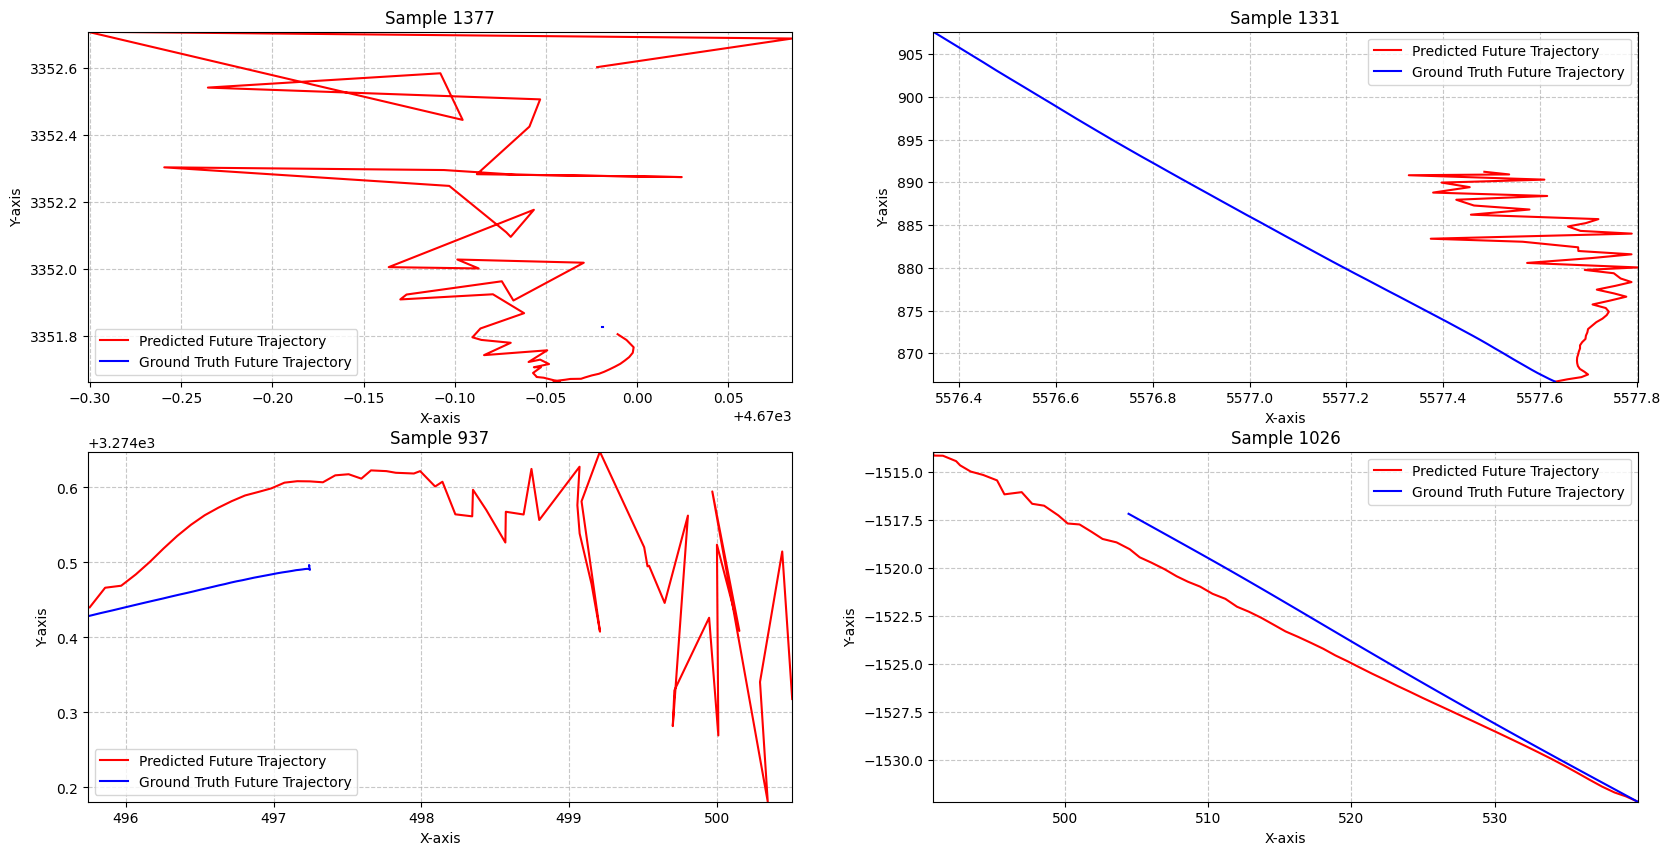

In [31]:
model.load_state_dict(torch.load("best_model.pt"))
model.eval()

# randomly select 4 samples from the validation set
random_indices = random.sample(range(len(val_dataset)), 4)
fig, axes = plt.subplots(2, 2, figsize=(20, 10))
axes = axes.flatten()  # Flatten the array to iterate single axes objects

for i, idx in enumerate(random_indices):
    data = val_dataset[idx]
    batch = Batch.from_data_list([data]).to(device)
    pred = model(batch)
    gt = batch.y.view(batch.num_graphs, 60, 2)

    pred = pred * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
    gt = gt * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)

    pred = pred.detach().cpu().numpy()
    gt = gt.detach().cpu().numpy()

    plot_trajectory(axes[i], pred, gt, title=f"Sample {idx}")

plt.show()

#### Output your predictions of the best model on the test set

In [25]:
test_dataset = TrajectoryDatasetTest(test_data, scale=scale)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False,
                         collate_fn=lambda xs: Batch.from_data_list(xs))

best_model = torch.load("best_model.pt")
# model = AdvancedTransformerModel().to(device)
# model = MLP(50 * 50 * 6, 60 * 2).to(device)
# model = LSTM().to(device)
model = GNNTransformerLite(
    gnn_hidden=128,
    gnn_heads=4,
    gnn_layers=2,
    trans_dim=128,
    trans_heads=4,
    trans_layers=2,
    dropout=0.1
).to(device)
model.load_state_dict(best_model)
model.eval()

pred_list = []
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        pred_norm = model(batch)
        
        # Reshape the prediction to (N, 60, 2)
        pred = pred_norm * batch.scale.view(-1,1,1) + batch.origin.unsqueeze(1)
        pred_list.append(pred.cpu().numpy())

pred_list = np.concatenate(pred_list, axis=0)  # (N,60,2)
pred_output = pred_list.reshape(-1, 2)  # (N*60, 2)
output_df = pd.DataFrame(pred_output, columns=['x', 'y'])
output_df.index.name = 'index'
output_df.to_csv('submission.csv', index=True)

## Step 4: Summarize your experiments and results in table and figures in the submitted PDF file for Question 3 Problem A

## Step 5: Analyze the results, identify the issues and plan for the improvement in the submitted PDF file for Question 3 Problem B